# Negative and nonlinear coabundances through Pearson correlation

In [1]:
net_folder = '/root/host_home/luca/outputARACNE/'
meta_folder = '/root/host_home/luca/metadata/'
nb_dir = '/root/host_home/luca/nb_graphAnalysis/'
cell_type_key = 'cell_type_adjusted'
sample_key = 'sample'

In [ ]:
import os
os.chdir(nb_dir)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

import networkx as nx

In [240]:
# Draw G
def draw_graph(G, ax, title):
    pos = nx.spring_layout(G, seed=0)  # Set the position of the nodes
    nx.draw(G, pos, with_labels=True, node_size=170, font_size=8, font_family="sans-serif", edge_color='black', ax=ax)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=5, ax=ax)
    ax.set_title(title)
    ax.axis('off')  # Turn off the axis
    

def plot_corr_networks(time, corr_threshold=0.3, p_threshold=0.05):
    time_solo = time.split('_')[0]
    # Unstack the group counts
    groups = pd.read_csv(f'{meta_folder}/groups_{time_solo}_zuani.csv', index_col=0)
    groups.sort_values([cell_type_key, sample_key])
    groups.set_index([cell_type_key,sample_key], inplace=True)
    cutoff = groups
    samp_type = cutoff.unstack().transpose()

    # Export a fig of missing samples
    plt.figure(figsize=(14, 9))  # Increase figure size
    plt.bar(samp_type.columns, samp_type.isna().sum())
    plt.ylabel('# missing samples')
    plt.title('# Samples with no Cell Type')
    plt.xticks(rotation=90)
    plt.savefig(f'{nb_dir}/output/missing_samples_{time}.png')
    plt.close()

    # Normalize the counts
    samp_type = samp_type.fillna(0)
    corr_types = (samp_type.T / samp_type.T.sum()).T
    corr_types.reset_index(inplace=True)
    corr_types.index = corr_types[sample_key]
    del corr_types[sample_key]
    del corr_types['level_0']

    # Compute pairwise correlations and p-values
    data = corr_types.to_numpy().T
    # Initialize matrices for correlation coefficients and p-values
    n_variables = data.shape[0]  # Number of variables, eg. cell types``
    pearson_matrix = np.zeros((n_variables, n_variables))
    pearson_p_values = np.zeros((n_variables, n_variables))

    for i in range(n_variables):
        for j in range(n_variables):
            if i == j:
                # The correlation of a variable with itself is always 1, and the p-value is 0
                pearson_matrix[i, j] = 1
                pearson_p_values[i, j] = 0
            elif i < j:
                # Compute correlation and p-value for unique pairs only
                correlation, p_value = pearsonr(data[i], data[j])
                if np.isnan(correlation):
                    print(f'Correlation between {corr_types.columns[i]} and {corr_types.columns[j]} is NaN')
                    correlation = 0
                    p_value = 1
                pearson_matrix[i, j] = pearson_matrix[j, i] = correlation
                pearson_p_values[i, j] = pearson_p_values[j, i] = p_value
                
    pearson_df = pd.DataFrame(pearson_matrix, columns=samp_type.columns, index=samp_type.columns)
    pearson_p_values_df = pd.DataFrame(pearson_p_values, columns=samp_type.columns, index=samp_type.columns)

    # Export the correlation matrix
    pearson_df.to_csv(f'{nb_dir}/output/pearson_{time_solo}.csv')
    pearson_p_values_df.to_csv(f'{nb_dir}/output/pearson_p_values_{time_solo}.csv')

    G = nx.Graph()

    # Add edges between all nodes with correlation as edge attribute
    for col1 in pearson_df.columns:
        for col2 in pearson_df.index:
            if col1 != col2:
                # Add an edge between col1 and col2 with the correlation as an attribute
                G.add_edge(col1, col2, weight=(round(pearson_df.loc[col1, col2],2)))

    # Remove edges with very low correlation and high p-value
    threshold = corr_threshold
    threshold_p = p_threshold
    for (u, v, d) in list(G.edges(data=True)):        
        if abs(d['weight']) < threshold or abs(pearson_p_values_df.loc[u, v]) > threshold_p:
            G.remove_edge(u, v)

    # Remove all nodes with no edges
    nodes_with_no_edges = [node for node, degree in G.degree() if degree == 0]
    G.remove_nodes_from(nodes_with_no_edges)

    # Save the corr_threshold as an attribute of the graph G
    G.graph['corr_threshold'] = corr_threshold

    # Subset to only edges with negative weight
    negative_edges = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < 0]
    positive_edges = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] > 0]
    G_negative = G.edge_subgraph(negative_edges).copy()
    G_positive = G.edge_subgraph(positive_edges).copy()

    _, axes = plt.subplots(1, 3, figsize=(22, 9))  # Create a figure with 2 subplots

    draw_graph(G, axes[0], f'Pearson Corr {time}')

    draw_graph(G_negative, axes[1], f'Negative Corr {time}')

    draw_graph(G_positive, axes[2], f'Positive Corr {time}')

    plt.show()

    return G, G_negative, G_positive, corr_types


def get_nonlinear_edges(time, G_pear):

    G_MI = nx.read_edgelist(f"{net_folder}/net{time}.txt", data=(("MI", float),('p', float)), delimiter='\t')

    # Ensure edges are ordered lexicographically and keep edge attributes
    edges_MI = [(min(u, v), max(u, v)) for u, v in G_MI.edges()]
    edges_pear = [(min(u, v), max(u, v)) for u, v in G_pear.edges()]

    non_linear_edges = set(edges_MI) - set(edges_pear)
    non_signif_edges = set(edges_pear) - set(edges_MI)
    thres = G_pear.graph['corr_threshold']
    print(f'Total MI edges: {len(edges_MI)}')
    print(f'Non linear edges # for {time} with thres={thres}:', len(non_linear_edges))
    return non_linear_edges, non_signif_edges, G_MI

In [197]:
thres = 0.2

## I-II

In [241]:
time = 'I-II_leiden'

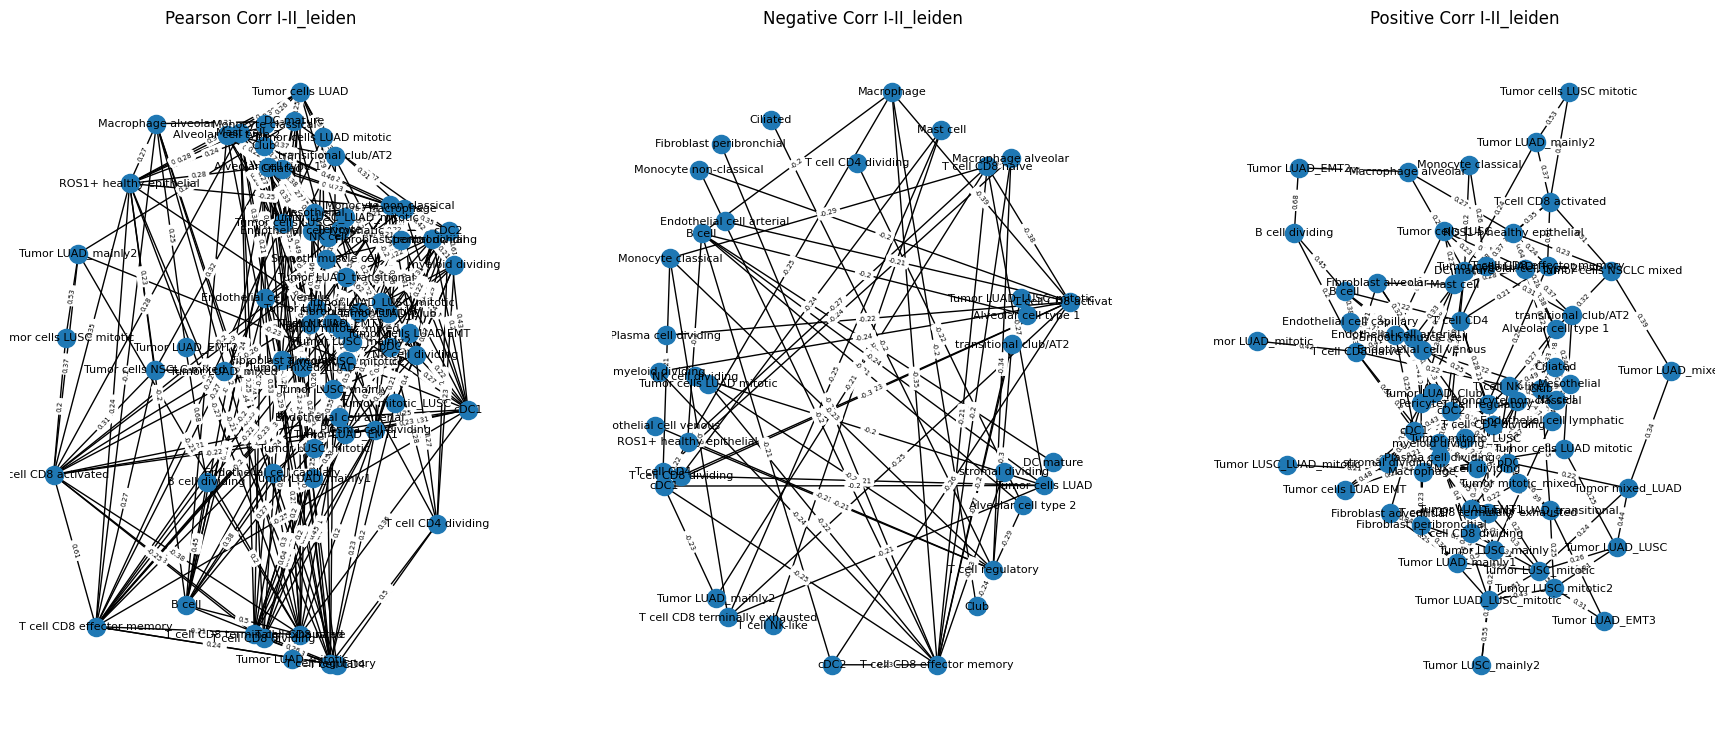

In [242]:
G_I, G_I_neg, G_I_pos, corr_types_I = plot_corr_networks(time, corr_threshold=thres, p_threshold=0.05,)

In [244]:
non_linear_I, non_signif_I, G_MI_I =  get_nonlinear_edges(time, G_I)

Total MI edges: 193
Non linear edges # for I-II_leiden with thres=0.2: 128


## III-IV

In [201]:
time = 'III-IV_leiden'

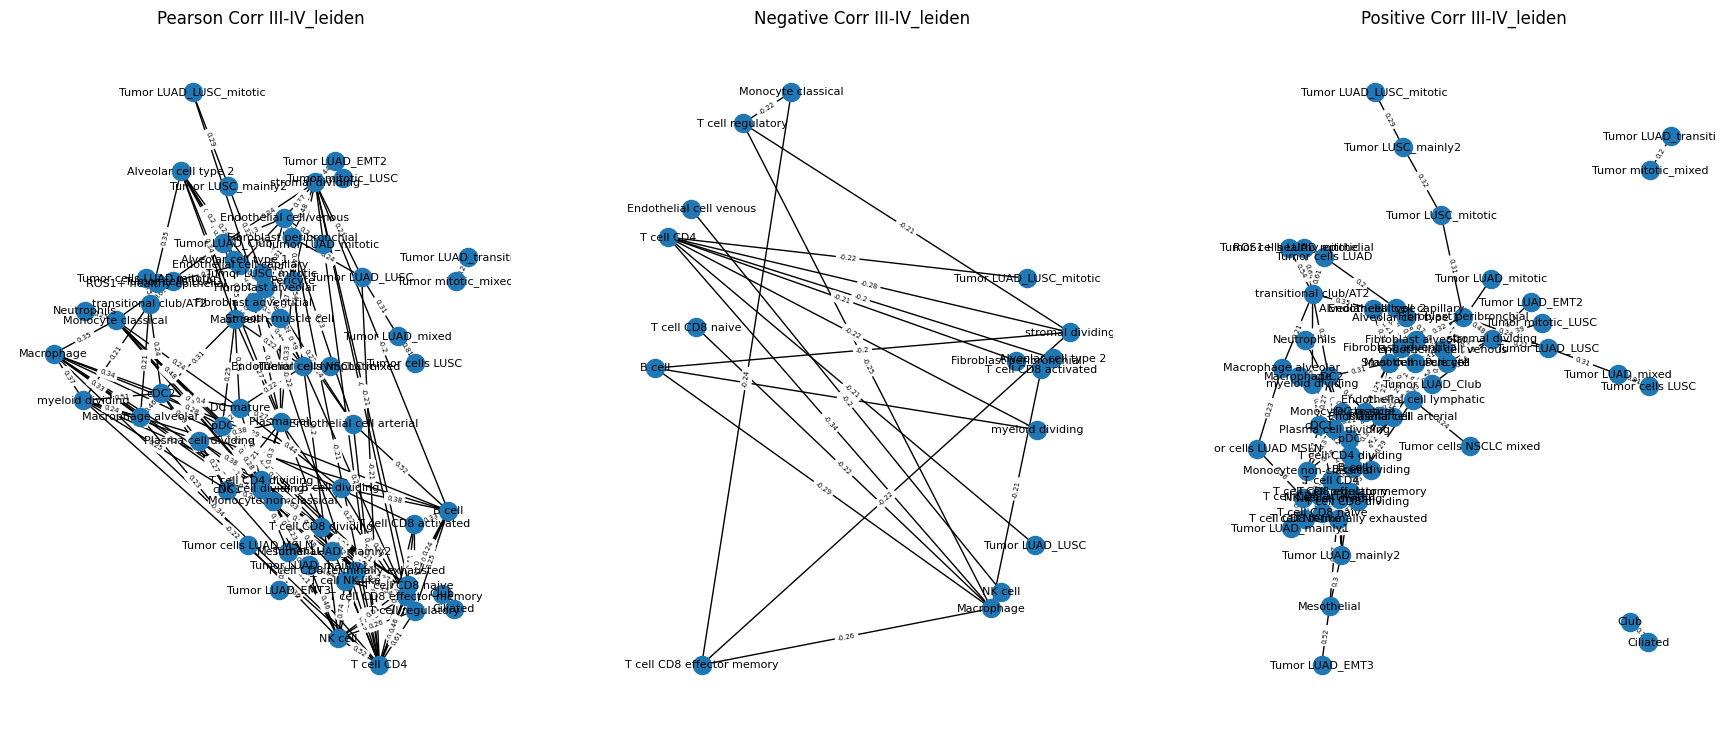

In [202]:
G_III, G_III_neg, G_III_pos, corr_types_III = plot_corr_networks(time, corr_threshold=thres, p_threshold=0.05,)

In [203]:
non_linear_III, non_signif_III, G_MI_III =  get_nonlinear_edges(time, G_III)

Total MI edges: 162
Non linear edges # for III-IV_leiden with thres=0.2: 75


In [ ]:
def sample_scatter(time, edge_diff, corr_types, G_MI, n=6, indices=[], log=False):
    
    if len(indices)>0:
        n = len(indices)
        sample_edges = [list(edge_diff)[i] for i in indices]
    else:
        inds = np.random.choice(len(edge_diff), n, replace=False)
        sample_edges = [list(edge_diff)[i] for i in inds]

    time_solo = time.split('_')[0]
    pearson_df = pd.read_csv(f'{nb_dir}/output/pearson_{time_solo}.csv', index_col=0)
    pearson_p_values_df = pd.read_csv(f'{nb_dir}/output/pearson_p_values_{time_solo}.csv', index_col=0)
    corr_types['dataset'] = corr_types.index.str.split('_').str[0] + '_' + corr_types.index.str.split('_').str[1]
    # Create a mapping of colors from dataset to colors
    unique_datasets = corr_types['dataset'].unique()
    colors = plt.cm.get_cmap('tab20', len(unique_datasets))
    color_mapping = {dataset: colors(i) for i, dataset in enumerate(unique_datasets)}
    corr_types['dataset'] = corr_types['dataset'].map(color_mapping)
    # Create scatterplots for each pair
    fig, axes = plt.subplots((n-1)//4 + 1, 4, figsize=(12, 3*((n-1)//4) ) )  # Create a figure with n subplots

    for ax, (var1, var2) in zip(axes.flatten(), sample_edges):
        ax.scatter(corr_types[var1], corr_types[var2], s=2, c=corr_types['dataset'])
        if log:
            ax.set_xscale('log')
            ax.set_yscale('log')
        ax.set_xlabel(var1)
        ax.set_ylabel(var2)
        corr = round(pearson_df.loc[var1, var2], 2)
        pval = round(pearson_p_values_df.loc[var1, var2], 4)
        try:
            mi = round(G_MI[var1][var2]["MI"], 2)
        except:
            mi = '<0.22'
        ax.set_title(f'P corr: {corr}, pval: {pval} MI: {mi}', size=9)

    plt.tight_layout()
    plt.show()

pDC andT cell CD8 effector memory have veryh high MI 0.43 but super low corr and very high pval, when looking at the scatter plot it looks like there are some isolated trends, maybe they are correlated with the dataset.
 

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not sample
Chen_Zhang_2020_NSCLC-1        Chen_Zhang_2020_NSCLC
Chen_Zhang_2020_NSCLC-11       Chen_Zhang_2020_NSCLC
Chen_Zhang_2020_NSCLC-2        Chen_Zhang_2020_NSCLC
Chen_Zhang_2020_NSCLC-3        Chen_Zhang_2020_NSCLC
Chen_Zhang_2020_NSCLC-6        Chen_Zhang_2020_NSCLC
                                      ...           
Zilionis_Klein_2019_p4t1    Zilionis_Klein_2019_p4t1
Zilionis_Klein_2019_p4t2    Zilionis_Klein_2019_p4t2
Zilionis_Klein_2019_p4t3    Zilionis_Klein_2019_p4t3
Zilionis_Klein_2019_p6t1    Zilionis_Klein_2019_p6t1
Zilionis_Klein_2019_p6t2    Zilionis_Klein_2019_p6t2
Name: dataset, Length: 119, dtype: object

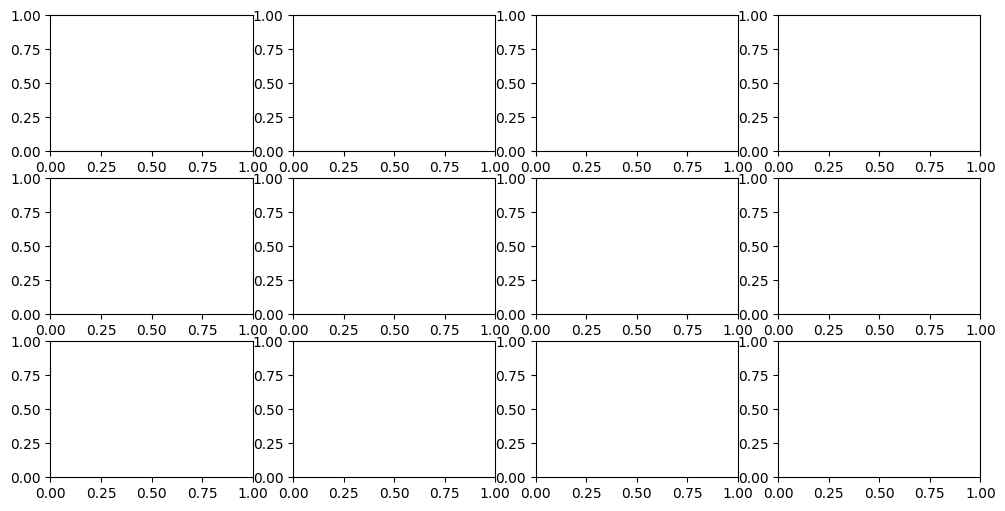

In [253]:
# sample_scatter(time, non_linear_I, corr_types_I, G_MI_I, indices=list(range(0,6)), log=False)
inds = np.random.choice(len(non_linear_I), 12, replace=False)
sample_scatter(time, non_linear_I, corr_types_I, G_MI_I, indices=inds, log=False)
sample_scatter(time, non_linear_I, corr_types_I, G_MI_I, indices=inds, log=True)

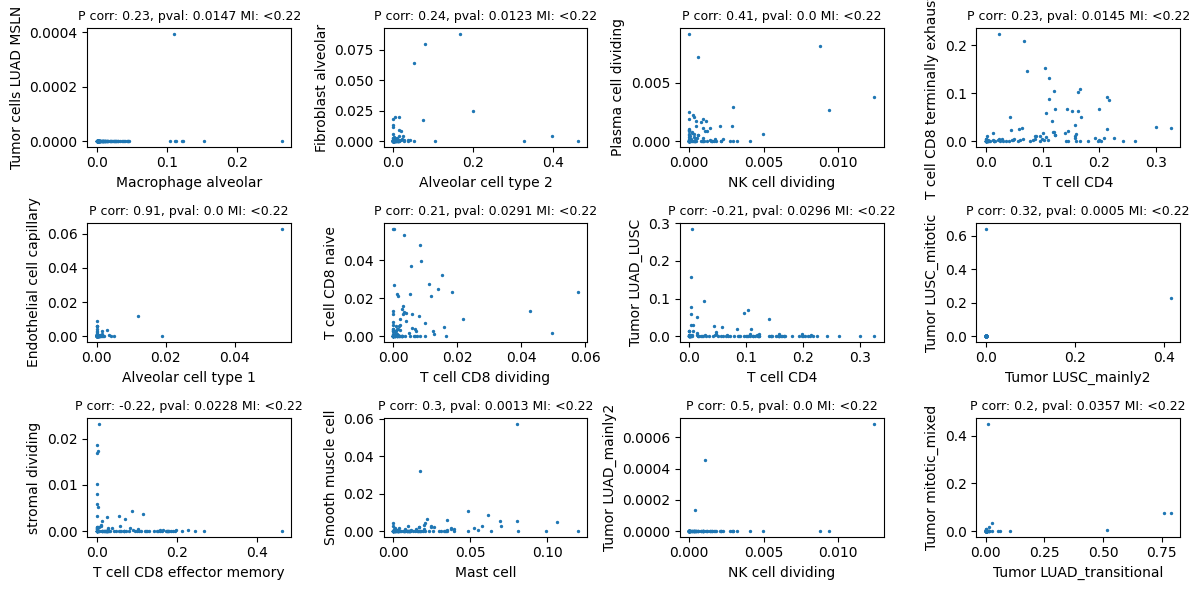

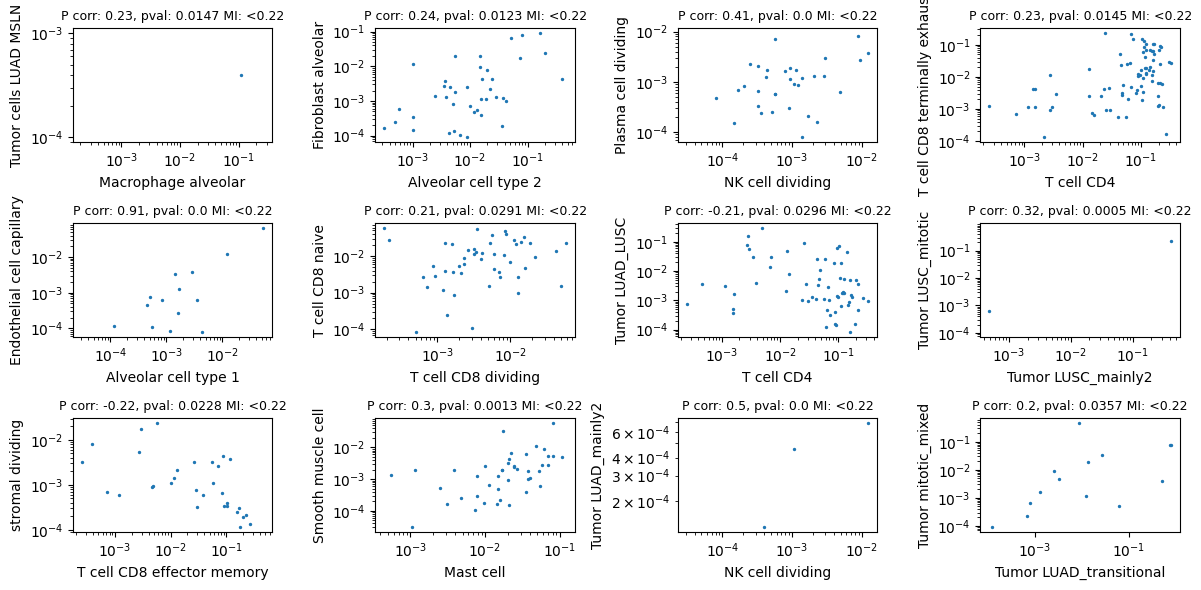

In [232]:
inds = np.random.choice(len(non_signif_I), 12, replace=False)
sample_scatter(time, non_signif_I, corr_types_I, G_MI_I, indices=inds, log=False)
sample_scatter(time, non_signif_I, corr_types_I, G_MI_I, indices=inds, log=True)

## Conditional MI

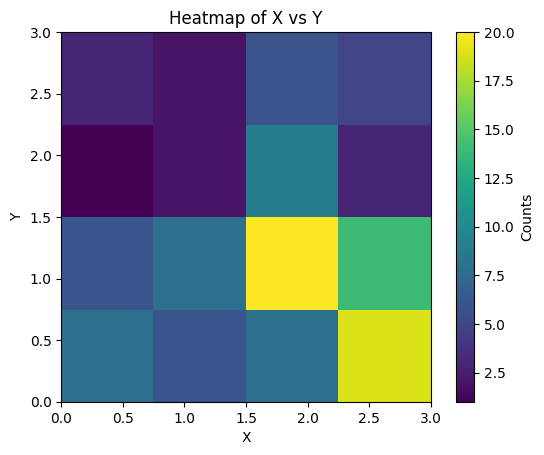

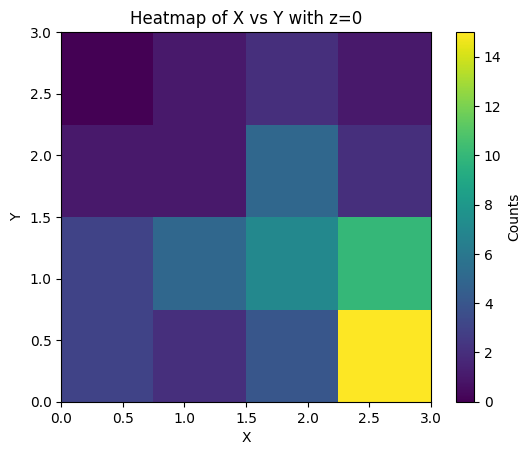

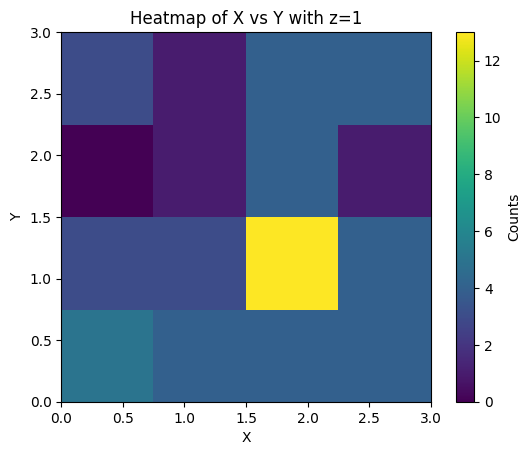

Conditional Mutual Information I(X; Y | Z): 0.0984
Mutual Information together I(X; Y): 0.0463
Mutual Information z=1 I(X1; Y1): 0.0825
Mutual Information z=0 I(X0; Y0): 0.0766


In [31]:
import numpy as np
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt

# Function to compute mutual information between two discrete variables
def mutual_information(x, y):
    return mutual_info_score(x, y)

# Function to compute conditional mutual information I(X;Y|Z)
def conditional_mutual_information_pandas(x, y, z):
    df = pd.DataFrame({'x': x, 'y': y, 'z': z})
    n = len(df)

    # Compute joint probabilities
    p_xyz = df.groupby(['x', 'y', 'z']).size() / n
    p_xz = df.groupby(['x', 'z']).size() / n
    p_yz = df.groupby(['y', 'z']).size() / n
    p_z = df.groupby(['z']).size() / n

    cmi = 0.0

    # Iterate over all combinations
    for (x_val, y_val, z_val), p_xyzi in p_xyz.items():
        p_xzi = p_xz[(x_val, z_val)]
        p_yzi = p_yz[(y_val, z_val)]
        p_zi = p_z[z_val]

        # Compute contribution to CMI
        cmi += p_xyzi * np.log(p_xyzi * p_zi / (p_xzi * p_yzi))

    return cmi

# Example data
# Assume x, y, z are discrete variables encoded as integer arrays
# For demonstration, we'll generate sample data
np.random.seed(42)

# Sample size
n = 120

# Confounding variable Z
z = np.random.choice([0, 1], size=n, p=[0.5, 0.5])

z_1 = [x for x in z if x==1]
z_0 = [x for x in z if x==0]

# Variables X and Y influenced by Z
x_1 = np.random.choice([0, 1, 2, 3], size=len(z_1), p=[0.2, 0.1, 0.4, 0.3])
y_1 = np.random.choice([0, 1, 2, 3], size=len(z_1), p=[0.3, 0.4, 0.1, 0.2])

x_0 = np.random.choice([0, 1, 2, 3], size=len(z_0), p=[0.1, 0.2, 0.3, 0.4])
y_0 = np.random.choice([0, 1, 2, 3], size=len(z_0), p=[0.4, 0.3, 0.2, 0.1])

x = np.concatenate((x_0, x_1))
y = np.concatenate((y_0, y_1))

# Scatter plot of X vs Y
# Create a heatmap of X vs Y
heatmap, xedges, yedges = np.histogram2d(x, y, bins=(4, 4))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='viridis')
plt.colorbar(label='Counts')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Heatmap of X vs Y')
plt.show()

heatmap, xedges, yedges = np.histogram2d(x_0, y_0, bins=(4, 4))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='viridis')
plt.colorbar(label='Counts')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Heatmap of X vs Y with z=0')
plt.show()

heatmap, xedges, yedges = np.histogram2d(x_1, y_1, bins=(4, 4))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='viridis')
plt.colorbar(label='Counts')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Heatmap of X vs Y with z=1')
plt.show()

# Compute conditional mutual information I(X; Y | Z)
cmi_xy_z = conditional_mutual_information_pandas(x, y, z)
mi_x_y_z = mutual_information(x, y )
mi_x1_y1 = mutual_information(x_1, y_1)
mi_x0_y0 = mutual_information(x_0, y_0)

print(f"Conditional Mutual Information I(X; Y | Z): {cmi_xy_z:.4f}")
print(f"Mutual Information together I(X; Y): {mi_x_y_z:.4f}")
print(f"Mutual Information z=1 I(X1; Y1): {mi_x1_y1:.4f}")
print(f"Mutual Information z=0 I(X0; Y0): {mi_x0_y0:.4f}")